In [150]:
#-- For data handling
import xarray as xr
import pandas as pd
import numpy as np
#-- For plotting
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
#-- lanczos filter
from oceans.filters import lanc
#-- for EOFs
from eofs.xarray import Eof
from scipy import signal
#-- for regridding
import xesmf as xe

ModuleNotFoundError: No module named 'xesmf'

# Open tas MIROC6 files through opendap

In [2]:
tas1 = xr.open_dataset('http://esgf-data2.diasjp.net/thredds/dodsC/esg_dataroot/CMIP6/CMIP/MIROC/MIROC6/historical/r1i1p1f1/Amon/tas/gn/v20181212/tas_Amon_MIROC6_historical_r1i1p1f1_gn_185001-194912.nc', decode_times=True)
tas2 = xr.open_dataset('http://esgf-data2.diasjp.net/thredds/dodsC/esg_dataroot/CMIP6/CMIP/MIROC/MIROC6/historical/r1i1p1f1/Amon/tas/gn/v20181212/tas_Amon_MIROC6_historical_r1i1p1f1_gn_195001-201412.nc', decode_times=True)
tas = xr.concat([tas1,tas2], dim='time')

# Seasonal means

In [70]:
# Seasonal mean
tas_seas = tas['tas'].groupby('time.season').mean('time') - 273.15

# Quick plot with xarray

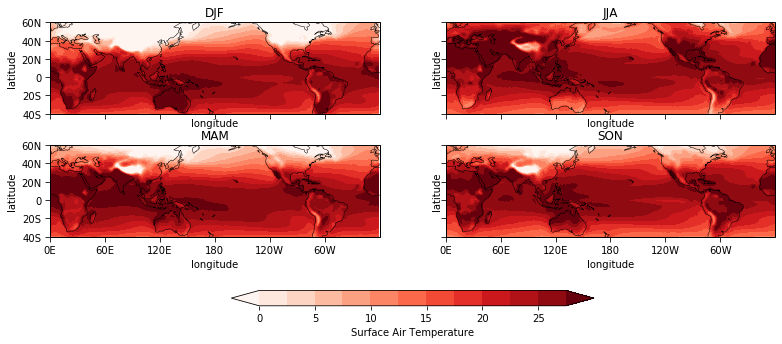

In [95]:
fig, ax = plt.subplots(2, 2, figsize=(13,4),subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180.0)),sharex = True, sharey = True)
ax = ax.flatten()

cmap = plt.get_cmap('Reds')
for itr,axi in enumerate(ax) :
    
    cf = tas_seas.isel(season=itr).plot.contourf(ax=axi, cmap=cmap, transform=ccrs.PlateCarree(),extend="both", add_colorbar = False,
                                           levels=np.arange(0,30,2.5))

    limits = (0,359,-40,60)
    xaxis_interval = 60
    yaxis_interval = 20
 
    axi.coastlines(linewidth=0.5)
    axi.set_title(tas_seas.isel(season=itr)['season'].values)
    axi.set_extent(limits)
    axi.set_xticks(np.arange(limits[0],limits[1]+1,xaxis_interval), crs=ccrs.PlateCarree())
    axi.set_yticks(np.arange(limits[2],limits[3]+1,yaxis_interval), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True, degree_symbol='')
    lat_formatter = LatitudeFormatter(degree_symbol='')
    axi.xaxis.set_major_formatter(lon_formatter)
    axi.yaxis.set_major_formatter(lat_formatter)
    axi.tick_params(direction = 'out', length = 5)
    axi.set_aspect('equal', 'box')
    axi.set_xlabel('longitude')
    axi.set_ylabel('latitude')

cbar = fig.colorbar(cf,ax = ax, orientation = 'horizontal',extendfrac='auto', shrink=0.5, anchor=(0.5,-4), label = 'Surface Air Temperature',)
plt.subplots_adjust(hspace=0.3)
plt.savefig('tas_seasons.png', orientation='landscape',dpi=100)

# Selection per slice and position


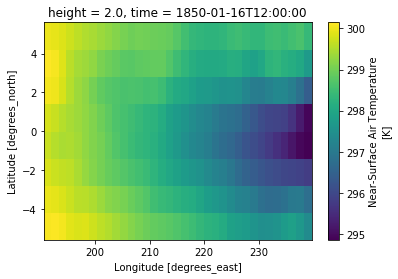

In [97]:
nino34_area = tas.sel(lat=slice(-5,5), lon=slice(190,240))
nino34_area['tas'].isel(time=0).plot()

# NINO3.4 index

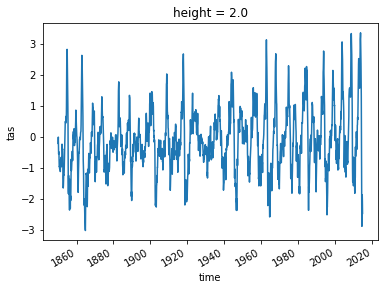

In [126]:
baseline = nino34_area.sel(time=slice('1961','1990'))
baseline_average = baseline.groupby('time.month').mean(dim='time')

anomaly = nino34_area.groupby('time.month') - baseline_average
nino34_index = anomaly.mean(dim=('lat','lon'))
nino34_index['tas'].plot()

# Resampling

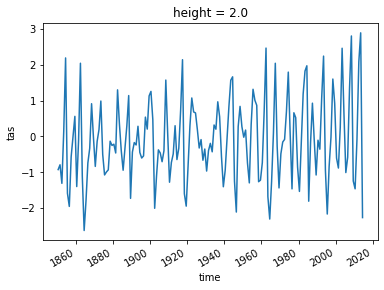

In [134]:
nino34_index_6M = nino34_index.resample(time='6MS').mean().sel(time = slice('1850-06','2014-12',2))
nino34_index_6M.tas.plot()
ntime = nino34_index_6M.dims['time']

# Detrending using polyfit


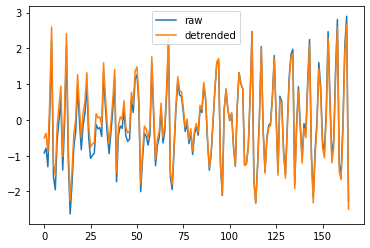

In [136]:
z = np.polyfit(x = np.arange(ntime), y = nino34_index_6M.tas, deg = 2)
zza = np.polyval(z,np.arange(ntime))
plt.plot(nino34_index_6M.tas, label='raw')
plt.plot(nino34_index_6M.tas-zza, label='detrended')
plt.legend()

# Lowpass filter

In [145]:
freq = 1./13  
window_size = 13
pad = np.zeros(window_size) * np.NaN

wt = lanc(window_size, freq)
lowpass = np.convolve(wt, nino34_index_6M.tas - zza, mode='same')

# NINO3.4 pretty plot

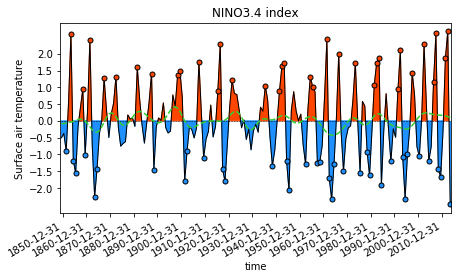

In [147]:
nino34_index_plot = nino34_index_6M.tas - zza
fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(3.50394*2,3.50394))

nino34_index_plot.plot(color='black', linewidth = 1)
plt.fill_between(nino34_index_plot.time.to_index(), 0, nino34_index_plot, where=nino34_index_plot > 0, interpolate=True, color = 'orangered')
plt.fill_between(nino34_index_plot.time.to_index(), 0, nino34_index_plot, where=nino34_index_plot < 0, interpolate=True, color = 'dodgerblue')


nino34_index_elnino = nino34_index_plot[nino34_index_plot > 0.8 * np.std(nino34_index_plot)]
plt.plot(nino34_index_elnino.time.to_index(),nino34_index_elnino, marker = 'o', linestyle = 'None', color = 'orangered', markersize = 5, markeredgecolor = 'black')
nino34_index_lanina = nino34_index_plot[nino34_index_plot < -0.8 * np.std(nino34_index_plot)]
plt.plot(nino34_index_lanina.time.to_index(),nino34_index_lanina, marker = 'o', linestyle = 'None', color = 'dodgerblue', markersize = 5, markeredgecolor = 'black')
plt.plot(nino34_index_plot.time.to_index(), np.repeat(0,ntime), linewidth = 0.5, linestyle ='--', color='black')
plt.ylabel('Surface air temperature')
plt.yticks(np.arange(-2,2.5,0.5))
plt.xticks(pd.date_range(start='1850',end = '2014', freq ='10Y'))
plt.xlim([pd.datetime(1850,1,1),pd.datetime(2014,12,31)])
plt.title('NINO3.4 index')

plt.plot(nino34_index_plot.time.to_index(),lowpass, color='limegreen', linestyle ='--')
plt.savefig('nino3.4.png', orientation='portrait', bbox_inches="tight", dpi = 200)

# ENSO & IPO empirical orthogonal functions

In [149]:
# Regrid
grid_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 1.5)), 'lon': (['lon'], np.arange(0, 360, 1.5))})

regridder = xe.Regridder(ts, grid_out, 'bilinear')
tas_regrid = regridder(tas['tas'])
tas_regrid

NameError: name 'xe' is not defined

In [ ]:
tsbox = tas.sel(lat=slice(-40,60), lon=slice(0,360))

# remove seasonal cycle
mon_avg = tsbox.groupby('time.month').mean(dim='time')
anomaly = tsbox.groupby('time.month') - mon_avg
# june to december averages
anomaly_jundec = anomaly.sel(time = slice('1850-06','2014-12') ).resample(time='6M').mean().sel(time = slice('1850-06','2014-12',2))
# detrend
anomaly_jundec_detrend = signal.detrend(anomaly_jundec['ts'], axis = 0)
anomaly_jundec_detrend = xr.DataArray(np.transpose(anomaly_jundec_detrend, axes = [0,1,2]), 
                                      dims={'time': 106, 'lat': 67, 'lon': 240},
                                      coords = anomaly_jundec['ts'].coords)
# land sea mask
mask = xr.open_dataset("/home/548/pfd548/data_visualisation/land-sea_mask/fractional_land.1.5-deg.nc").sel(lat=slice(-40,60), lon=slice(0,360))
mask50 = mask['data'].where( mask['data'] > 0.5, 0)
maske = np.repeat(mask50.values,106, axis = 0)
anomaly_jundec_detrend_masked = anomaly_jundec_detrend.where(maske == 0, 0)